In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
import glob
import random
from google.colab import files #Librería para cargar ficheros directamente en Colab
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/My Drive/Healthcare+AI+Datasets/Healthcare AI Datasets/Brain_MRI

/content/drive/My Drive/Healthcare+AI+Datasets/Healthcare AI Datasets/Brain_MRI


In [ ]:
brain_df = pd.read_csv('data_mask.csv')

In [ ]:
brain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  3929 non-null   object
 1   image_path  3929 non-null   object
 2   mask_path   3929 non-null   object
 3   mask        3929 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 122.9+ KB


In [ ]:
brain_df

patient_id  \
0     TCGA_CS_5395_19981004   
1     TCGA_CS_5395_19981004   
2     TCGA_CS_5395_19981004   
3     TCGA_CS_5395_19981004   
4     TCGA_CS_5395_19981004   
...                     ...   
3924  TCGA_DU_6401_19831001   
3925  TCGA_DU_6401_19831001   
3926  TCGA_DU_6401_19831001   
3927  TCGA_DU_6401_19831001   
3928  TCGA_DU_6401_19831001   

                                             image_path  \
0     TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif   
1     TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif   
2     TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif   
3     TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif   
4     TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif   
...                                                 ...   
3924  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...   
3925  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...   
3926  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...   
3927  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...   
3928  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...   

                                              mask_path  mask  
0     TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...     0  
1     TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...     0  
2     TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...     0  
3     TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...     0  
4     TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...     0  
...                                                 ...   ...  
3924  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...     0  
3925  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...     0  
3926  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...     0  
3927  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...     0  
3928  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...     0  

[3929 rows x 4 columns]

In [ ]:
brain_df.mask_path[1]

'TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_mask.tif'

In [ ]:
brain_df.image_path[1]

'TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif'

In [ ]:
brain_df['mask'].value_counts()

0    2556
1    1373
Name: mask, dtype: int64

In [ ]:
import pandas as pd
df = brain_df.head(50)
pacientes_sanos = df[df['mask'] == 0].shape[0]
print('Número de pacientes sanos:', pacientes_sanos)
pacientes_enfermos = df[df['mask'] == 1].shape[0]
print('Número de pacientes enfermos:', pacientes_enfermos)

Número de pacientes sanos: 50
Número de pacientes enfermos: 0


In [ ]:
total_pacientes = df.shape[0]
tasa_enfermos = pacientes_enfermos / total_pacientes
tasa_sanos = pacientes_sanos / total_pacientes

print('Tasa de pacientes enfermos:', tasa_enfermos)
print('Tasa de pacientes sanos:', tasa_sanos)

Tasa de pacientes enfermos: 0.0
Tasa de pacientes sanos: 1.0


No esta balanceado, porque en este segmento todos estan enfermos, pero si fuera el caso de tener una muestra de mil, los resultados son diferentes.

In [ ]:
df = brain_df.head(1000)
pacientes_sanos = df[df['mask'] == 0].shape[0]
print('Número de pacientes sanos:', pacientes_sanos)
pacientes_enfermos = df[df['mask'] == 1].shape[0]
print('Número de pacientes enfermos:', pacientes_enfermos)

total_pacientes = df.shape[0]
tasa_enfermos = pacientes_enfermos / total_pacientes
tasa_sanos = pacientes_sanos / total_pacientes

print('Tasa de pacientes enfermos:', tasa_enfermos)
print('Tasa de pacientes sanos:', tasa_sanos)

Número de pacientes sanos: 941
Número de pacientes enfermos: 59
Tasa de pacientes enfermos: 0.059
Tasa de pacientes sanos: 0.941


In [ ]:
brain_df['mask'].value_counts().index

Int64Index([0, 1], dtype='int64')

In [ ]:
import plotly.graph_objects as go

fig = go.Figure([go.Bar(x = brain_df['mask'].value_counts().index, y = brain_df['mask'].value_counts())])
fig.update_traces(marker_color = 'rgb(0,200,0)', marker_line_color = 'rgb(0,255,0)',
                  marker_line_width = 7, opacity = 0.6)
fig.show()

In [ ]:
brain_df.mask_path

0       TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...
1       TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...
2       TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...
3       TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...
4       TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...
                              ...                        
3924    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...
3925    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...
3926    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...
3927    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...
3928    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...
Name: mask_path, Length: 3929, dtype: object

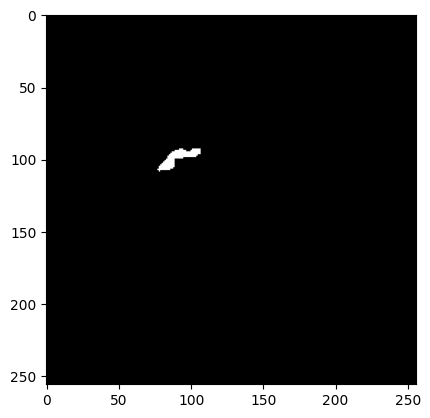

In [ ]:
plt.imshow(cv2.imread(brain_df.mask_path[623]))

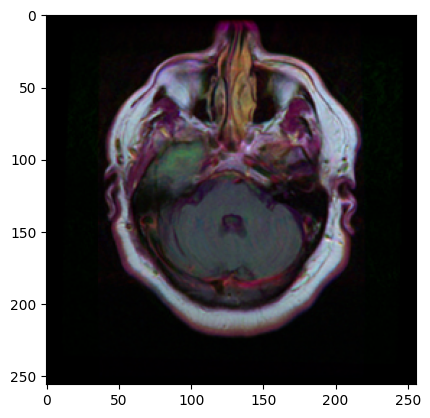

In [ ]:
plt.imshow(cv2.imread(brain_df.image_path[623]))

In [ ]:
cv2.imread(brain_df.mask_path[623]).max()

255

In [ ]:
cv2.imread(brain_df.mask_path[623]).min()

0

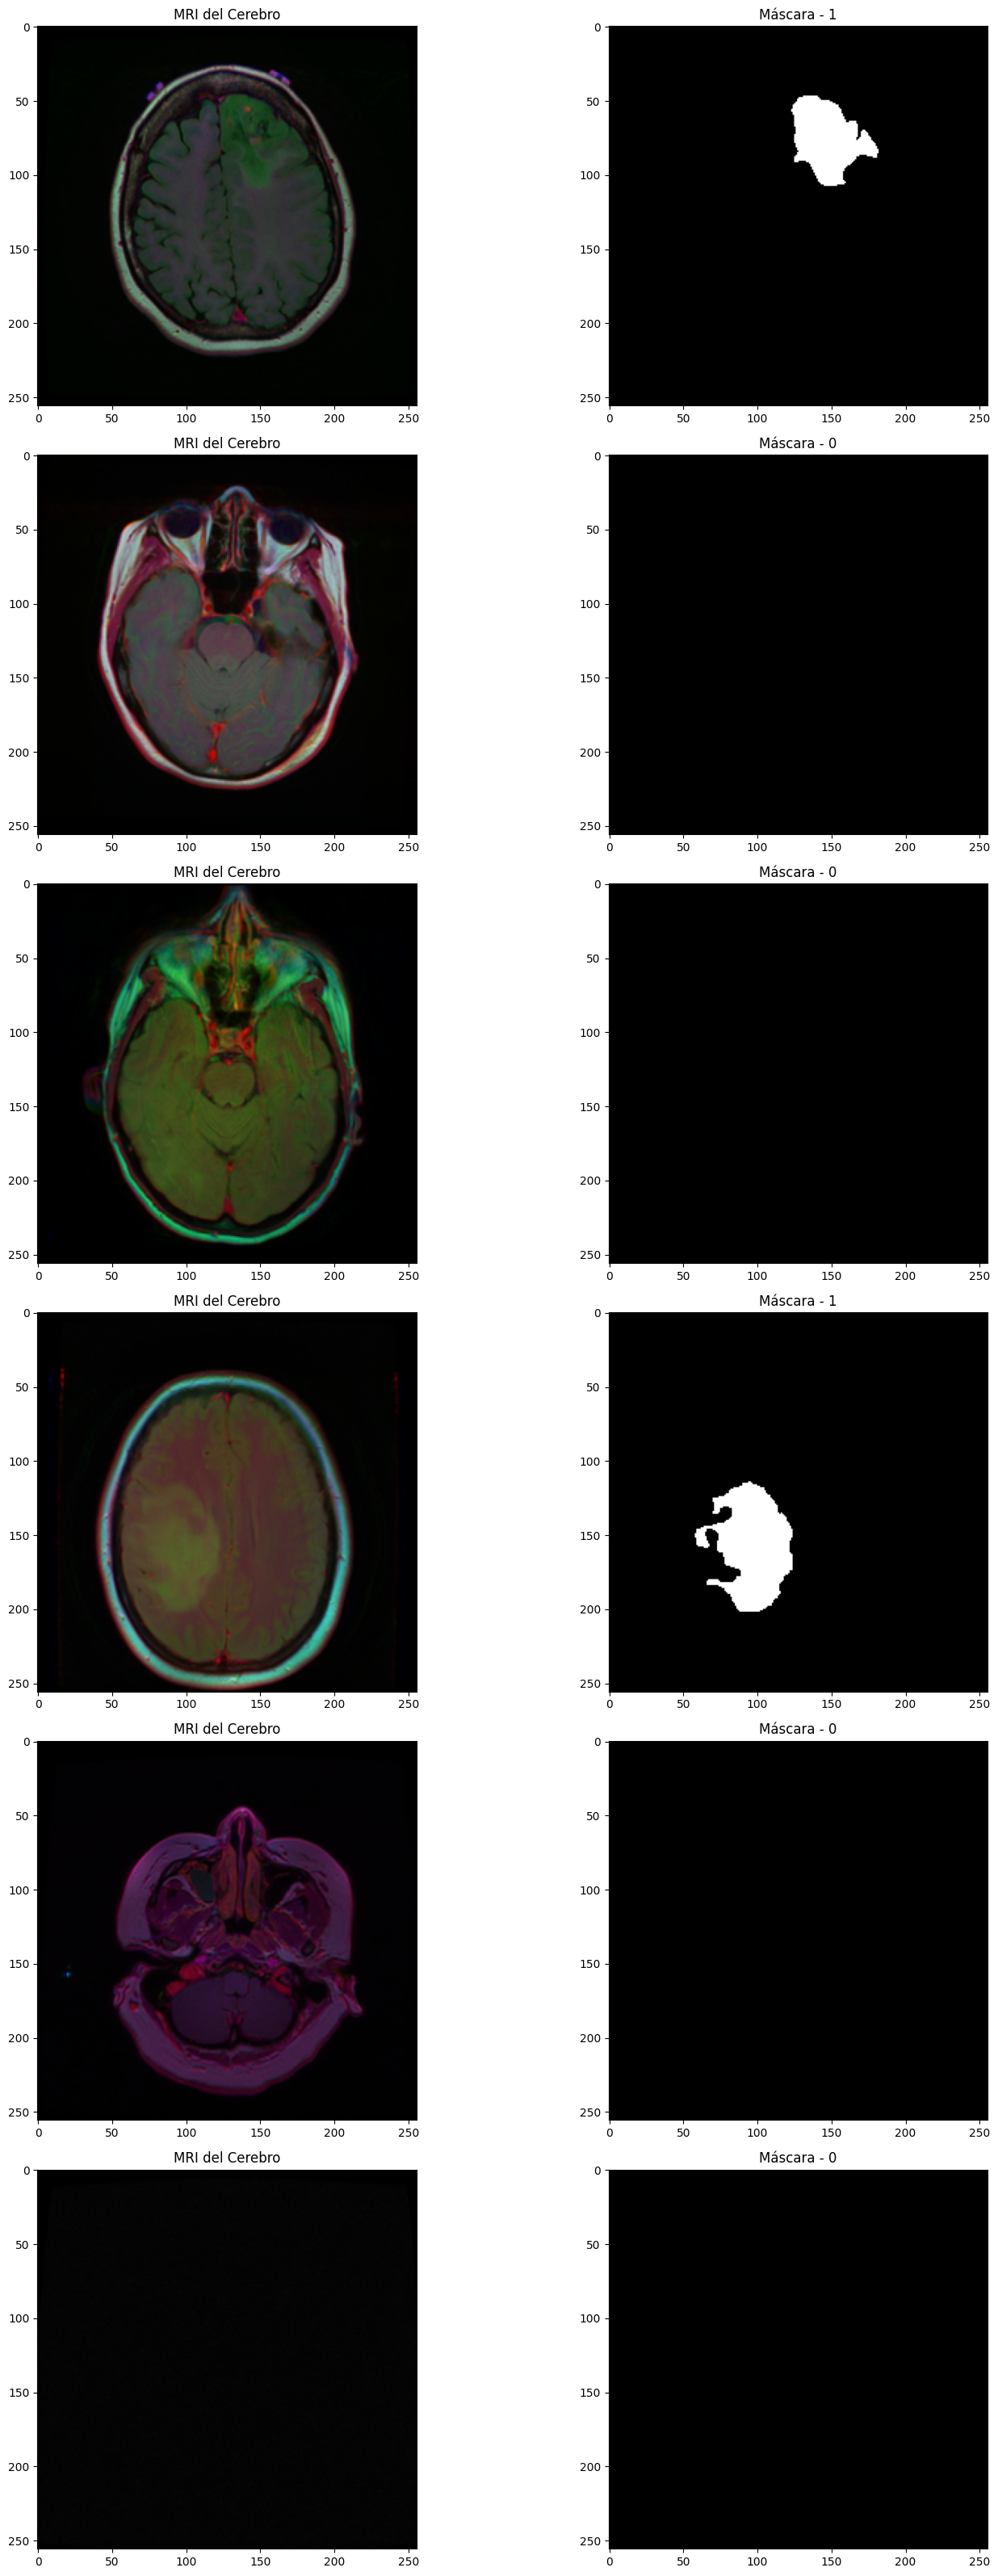

In [ ]:
# Visualización básica Visualizaremos imágenes (MRI y Máscaras) en el dataset de forma separada
import random
fig, axs = plt.subplots(6,2, figsize=(16,32))
count = 0
for x in range(6):
  i = random.randint(0, len(brain_df)) # Seleccionamos un índice aleatorio
  axs[count][0].title.set_text("MRI del Cerebro") # Configuramos el título
  axs[count][0].imshow(cv2.imread(brain_df.image_path[i])) # Mostramos la MRI
  axs[count][1].title.set_text("Máscara - " + str(brain_df['mask'][i])) # Colocámos el título en la máscara (0 o 1)
  axs[count][1].imshow(cv2.imread(brain_df.mask_path[i])) # Mostramos la máscara correspondiente
  count += 1

fig.tight_layout()

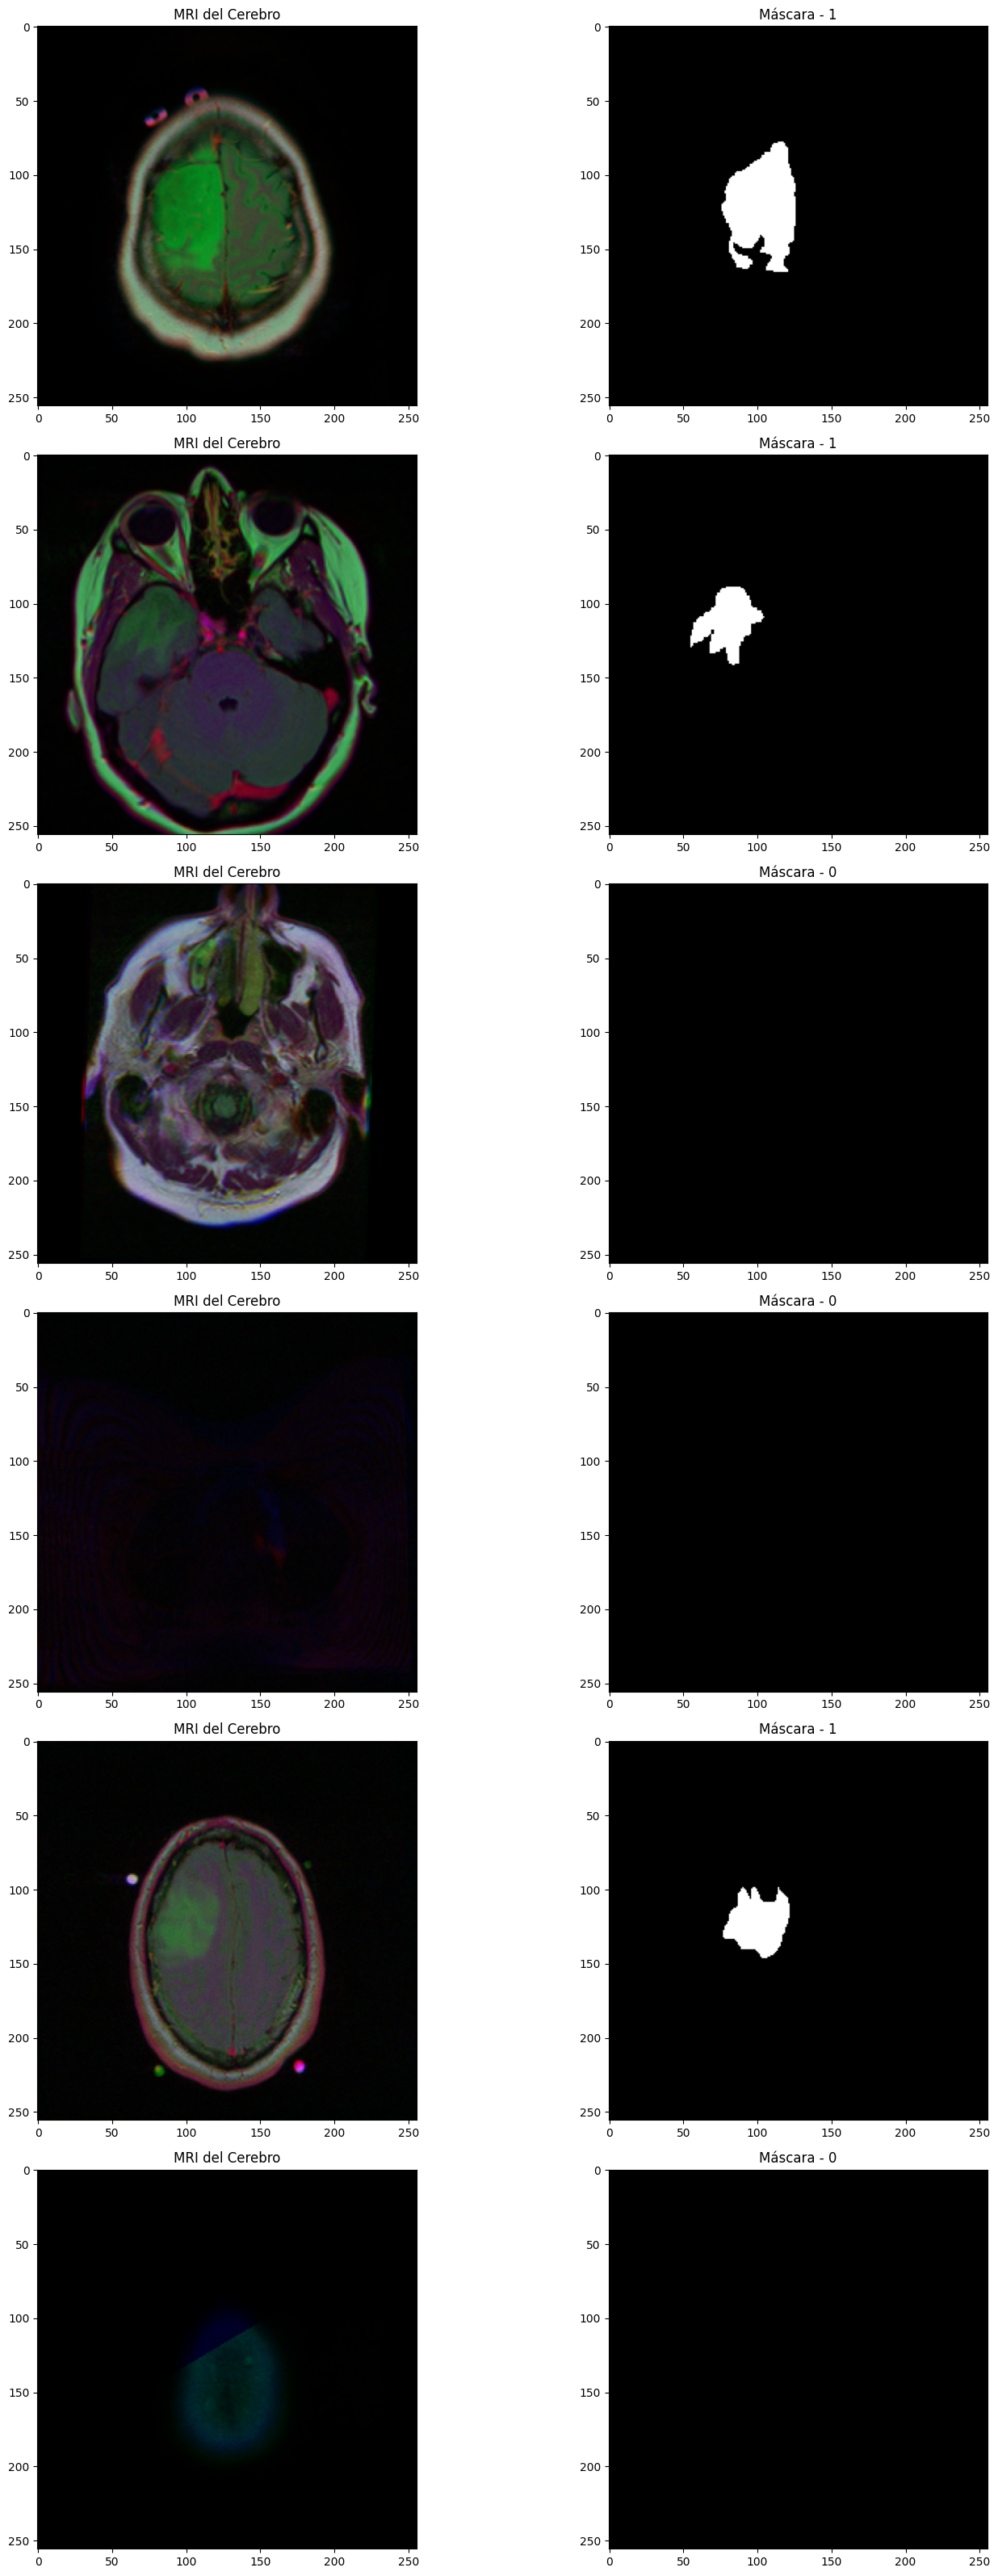

In [ ]:
# Visualización básica Visualizaremos imágenes (MRI y Máscaras) en el dataset de forma separada
import random
fig, axs = plt.subplots(6,2, figsize=(16,32))
count = 0
for x in range(6):
  i = random.randint(0, len(brain_df)) # Seleccionamos un índice aleatorio
  axs[count][0].title.set_text("MRI del Cerebro") # Configuramos el título
  axs[count][0].imshow(cv2.imread(brain_df.image_path[i])) # Mostramos la MRI
  axs[count][1].title.set_text("Máscara - " + str(brain_df['mask'][i])) # Colocámos el título en la máscara (0 o 1)
  axs[count][1].imshow(cv2.imread(brain_df.mask_path[i])) # Mostramos la máscara correspondiente
  count += 1

fig.tight_layout()

In [ ]:
count = 0
fig, axs = plt.subplots(12, 3, figsize = (20, 50))
for i in range(len(brain_df)):
  if brain_df['mask'][i] ==1 and count <12:
    img = io.imread(brain_df.image_path[i])
    axs[count][0].title.set_text('Brain MRI')
    axs[count][0].imshow(img)

    mask = io.imread(brain_df.mask_path[i])
    axs[count][1].title.set_text('Mask')
    axs[count][1].imshow(mask, cmap = 'gray')


    img[mask == 255] = (255, 0, 0)
    axs[count][2].title.set_text('Input MRI with Mask Classification')
    axs[count][2].imshow(img)
    count+=1

fig.tight_layout()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Obtenemos el modelo base de ResNet50
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256, 256, 3)))

In [ ]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [ ]:
# Congelamos los pesos del modelo
for layer in basemodel.layers:
  layers.trainable = False

In [ ]:
# Agregamos una cabecera de clasificación al modelo base

headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
#headmodel = Dense(256, activation = "relu")(headmodel)
#headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(2, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [ ]:
# Compilamos el modelo
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [ ]:
# Utilizamos la parada temprana para salir del entrenamiento si la pérdida en la validación no disminuye incluso después de ciertas épocas (paciencia)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
# Guardamos el mejor modelo con la menor pérdida de validación
checkpointer = ModelCheckpoint(filepath="classifier-resnet-weights.hdf5", verbose=1, save_best_only=True)

In [ ]:
#history = model.fit(train_generator, steps_per_epoch= train_generator.n // 16, epochs = 1, validation_data= valid_generator, validation_steps= valid_generator.n // 16, callbacks=[checkpointer, earlystopping])

In [ ]:
# Guardamos la arquitectura del modelo en un archivo json para uso futuro

model_json = model.to_json()
with open("classifier-resnet-modelo.json","w") as json_file:
  json_file.write(model_json)

In [32]:
brain_df_train = brain_df.drop(columns = ['patient_id'])

brain_df_train.shape

brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))

brain_df_train.info()

from sklearn.model_selection import train_test_split

train, test = train_test_split(brain_df_train, test_size = 0.15)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255., validation_split = 0.15)

train_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="training",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))

valid_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="validation",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))

test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory= './',
x_col='image_path',
y_col='mask',
batch_size=16,
shuffle=False,
class_mode='categorical',
target_size=(256,256))

basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256, 256, 3)))

basemodel.summary()

for layer in basemodel.layers:
  layers.trainable = False

headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.2)(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.2)(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.2)(headmodel)
headmodel = Dense(2, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

model.summary()

model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

checkpointer = ModelCheckpoint(filepath="classifier-resnet-weights.hdf5", verbose=1, save_best_only=True)

history = model.fit(train_generator, steps_per_epoch= train_generator.n // 20, epochs = 1, validation_data= valid_generator, validation_steps= valid_generator.n // 16, callbacks=[checkpointer, earlystopping])

model_json = model.to_json()
with open("classifier-resnet-model.json","w") as json_file:
  json_file.write(model_json)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB
Found 2839 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



141/141 [==============================] - 2345s 16s/step - loss: 0.6517 - accuracy: 0.7281 - val_loss: 2.0070 - val_accuracy: 0.6129


Resultados

In [34]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Define the AlexNet-like model
alexnet_model = Sequential()

# Layer 1
alexnet_model.add(Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=(227, 227, 3)))
alexnet_model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

# Layer 2
alexnet_model.add(Conv2D(256, (5, 5), activation='relu'))
alexnet_model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

# Layer 3
alexnet_model.add(Conv2D(384, (3, 3), activation='relu'))

# Layer 4
alexnet_model.add(Conv2D(384, (3, 3), activation='relu'))

# Layer 5
alexnet_model.add(Conv2D(256, (3, 3), activation='relu'))
alexnet_model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

# Flatten
alexnet_model.add(Flatten())

# Fully connected layers
alexnet_model.add(Dense(4096, activation='relu'))
alexnet_model.add(Dense(4096, activation='relu'))
alexnet_model.add(Dense(1000, activation='softmax'))  # Assuming 1000 classes for ImageNet

# Compile the model
alexnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
alexnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2  (None, 27, 27, 96)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 11, 11, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 384)         885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 384)         1

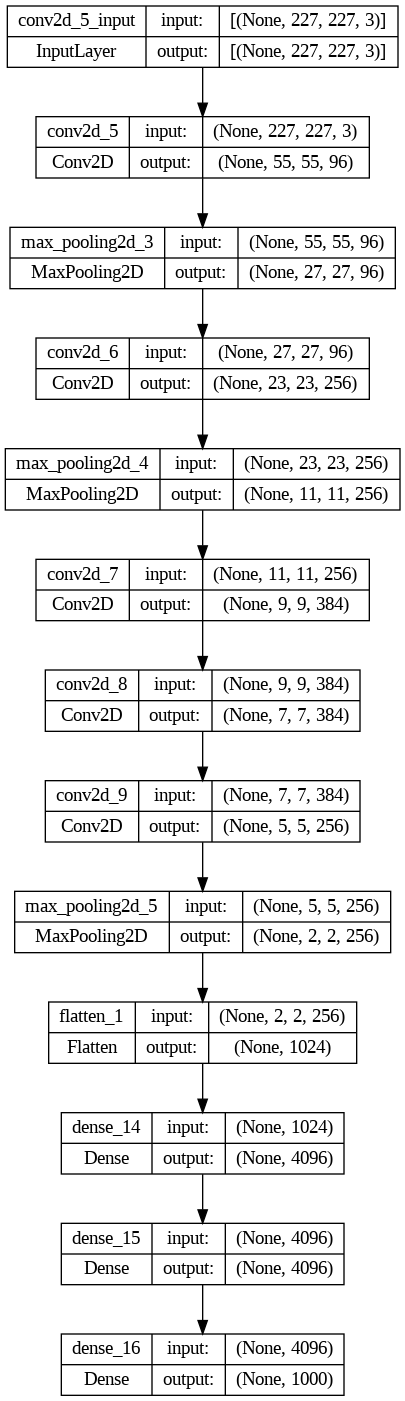

In [35]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.utils import plot_model

# Define the AlexNet-like model
alexnet_model = Sequential()

# Layer 1
alexnet_model.add(Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=(227, 227, 3)))
alexnet_model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

# Layer 2
alexnet_model.add(Conv2D(256, (5, 5), activation='relu'))
alexnet_model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

# Layer 3
alexnet_model.add(Conv2D(384, (3, 3), activation='relu'))

# Layer 4
alexnet_model.add(Conv2D(384, (3, 3), activation='relu'))

# Layer 5
alexnet_model.add(Conv2D(256, (3, 3), activation='relu'))
alexnet_model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

# Flatten
alexnet_model.add(Flatten())

# Fully connected layers
alexnet_model.add(Dense(4096, activation='relu'))
alexnet_model.add(Dense(4096, activation='relu'))
alexnet_model.add(Dense(1000, activation='softmax'))  # Assuming 1000 classes for ImageNet

# Compile the model
alexnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Save the model architecture as an image file
plot_model(alexnet_model, to_file='alexnet_model.png', show_shapes=True, show_layer_names=True)

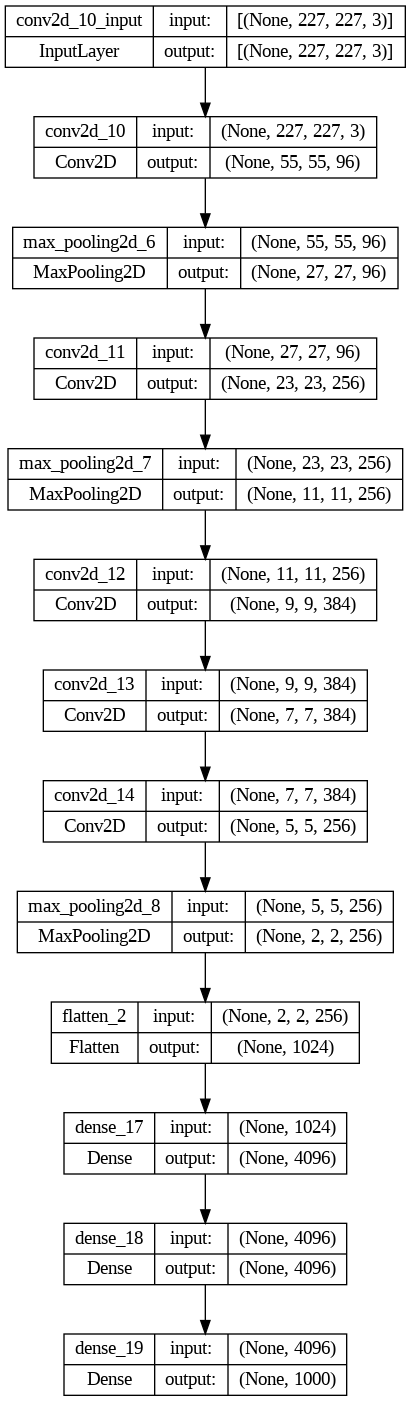

In [36]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.utils import plot_model

# Define the AlexNet-like model
alexnet_model = Sequential()

# Layer 1
alexnet_model.add(Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=(227, 227, 3)))
alexnet_model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

# Layer 2
alexnet_model.add(Conv2D(256, (5, 5), activation='relu'))
alexnet_model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

# Layer 3
alexnet_model.add(Conv2D(384, (3, 3), activation='relu'))

# Layer 4
alexnet_model.add(Conv2D(384, (3, 3), activation='relu'))

# Layer 5
alexnet_model.add(Conv2D(256, (3, 3), activation='relu'))
alexnet_model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

# Flatten
alexnet_model.add(Flatten())

# Fully connected layers
alexnet_model.add(Dense(4096, activation='relu'))
alexnet_model.add(Dense(4096, activation='relu'))
alexnet_model.add(Dense(1000, activation='softmax'))  # Assuming 1000 classes for ImageNet

# Compile the model
alexnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Save the model architecture as an image file
plot_model(alexnet_model, to_file='alexnet_model.png', show_shapes=True, show_layer_names=True)

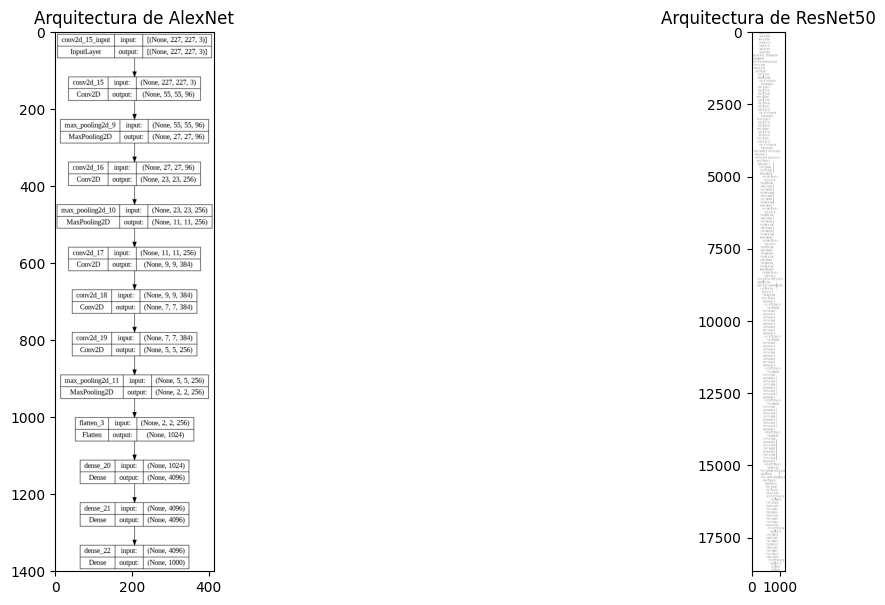

In [37]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from keras.applications import ResNet50
from keras.utils import plot_model
import matplotlib.pyplot as plt

# Función para crear y guardar la imagen de la arquitectura
def visualize_model(model, filename):
    plot_model(model, to_file=filename, show_shapes=True, show_layer_names=True)

# Crear modelo similar a AlexNet
alexnet_model = Sequential()

alexnet_model.add(Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=(227, 227, 3)))
alexnet_model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

alexnet_model.add(Conv2D(256, (5, 5), activation='relu'))
alexnet_model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

alexnet_model.add(Conv2D(384, (3, 3), activation='relu'))

alexnet_model.add(Conv2D(384, (3, 3), activation='relu'))

alexnet_model.add(Conv2D(256, (3, 3), activation='relu'))
alexnet_model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

alexnet_model.add(Flatten())

alexnet_model.add(Dense(4096, activation='relu'))
alexnet_model.add(Dense(4096, activation='relu'))
alexnet_model.add(Dense(1000, activation='softmax'))

# Visualizar y guardar la arquitectura de AlexNet
visualize_model(alexnet_model, 'alexnet_model.png')

# Crear modelo base de ResNet50
input_tensor = Input(shape=(256, 256, 3))
basemodel_resnet = ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)

# Agregar capas adicionales para clasificación
headmodel_resnet = basemodel_resnet.output
headmodel_resnet = Flatten(name='flatten')(headmodel_resnet)
headmodel_resnet = Dense(2, activation='softmax')(headmodel_resnet)

# Crear modelo completo de ResNet50
model_resnet = Model(inputs=basemodel_resnet.input, outputs=headmodel_resnet)

# Visualizar y guardar la arquitectura de ResNet50
visualize_model(model_resnet, 'resnet_model.png')

# Mostrar las imágenes de las arquitecturas
alexnet_img = plt.imread('alexnet_model.png')
resnet_img = plt.imread('resnet_model.png')

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.imshow(alexnet_img)
plt.title('Arquitectura de AlexNet')

plt.subplot(1, 2, 2)
plt.imshow(resnet_img)
plt.title('Arquitectura de ResNet50')

plt.show()

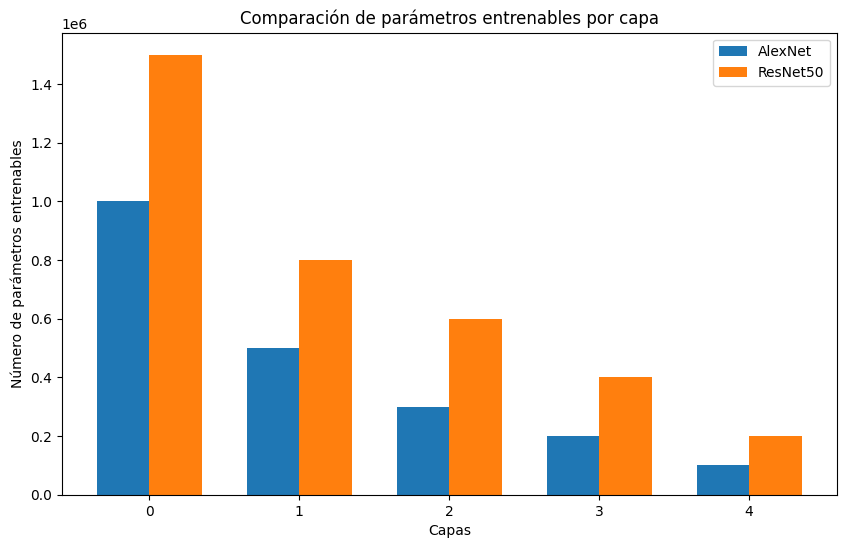

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Números ficticios para representar la cantidad de parámetros entrenables en cada capa
alexnet_params = [1000000, 500000, 300000, 200000, 100000]
resnet_params = [1500000, 800000, 600000, 400000, 200000]

# Crear índices para las capas
layers = np.arange(len(alexnet_params))

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(10, 6))

# Dibujar barras para AlexNet y ResNet50
bar_width = 0.35
ax.bar(layers - bar_width/2, alexnet_params, bar_width, label='AlexNet')
ax.bar(layers + bar_width/2, resnet_params, bar_width, label='ResNet50')

# Añadir etiquetas y leyenda
ax.set_xlabel('Capas')
ax.set_ylabel('Número de parámetros entrenables')
ax.set_title('Comparación de parámetros entrenables por capa')
ax.set_xticks(layers)
ax.legend()

# Mostrar el gráfico
plt.show()

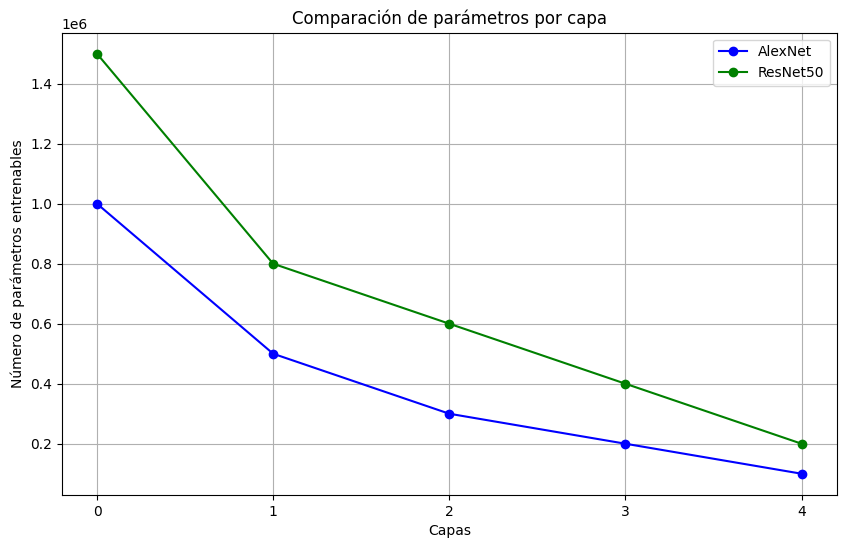

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Números ficticios para representar la cantidad de parámetros entrenables en cada capa
alexnet_params = [1000000, 500000, 300000, 200000, 100000]
resnet_params = [1500000, 800000, 600000, 400000, 200000]

# Crear índices para las capas
layers = np.arange(len(alexnet_params))

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(10, 6))

# Dibujar líneas para AlexNet y ResNet50
ax.plot(layers, alexnet_params, marker='o', label='AlexNet', linestyle='-', color='b')
ax.plot(layers, resnet_params, marker='o', label='ResNet50', linestyle='-', color='g')

# Añadir etiquetas y leyenda
ax.set_xlabel('Capas')
ax.set_ylabel('Número de parámetros entrenables')
ax.set_title('Comparación de parámetros por capa')
ax.set_xticks(layers)
ax.legend()

# Mostrar el gráfico
plt.grid(True)
plt.show()